

### Do not use scikit-learn API in section 1-3. 



In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import scipy.io as scio


<a id="section1"></a>
## 1 Regularized Linear Regression (20 pts)

In the first half of the exam, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s.
variance. 

### 1.1 Visualizing the dataset

We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$. This dataset is divided into three parts:

- A **training** set that your model will learn on: `X`, `y`
- A **cross validation** set for determining the regularization parameter: `Xval`, `yval`
- A **test** set for evaluating performance. These are “unseen” examples which your model did not see during training: `Xtest`, `ytest`

Run the next cell to plot the training data. In the following parts, you will implement linear regression and use that to fit a straight line to the data and plot learning curves. Following that, you will implement polynomial regression to find a better fit to the data.

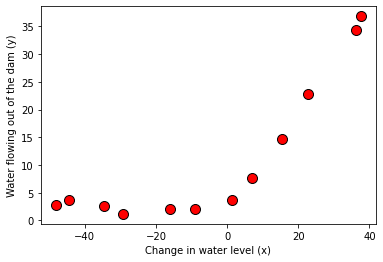

In [2]:
# Load from data1.mat, where all variables will be store in a dictionary
data = scio.loadmat('data1.mat')

# Extract train, test, validation data from dictionary
X = data['X']
y = data['y'].flatten()
Xval = data['Xval']
yval = data['yval'].flatten()
Xtest = data['Xtest']
ytest = data['ytest'].flatten()

# m = Number of examples
m = y.size

# Plot training data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)');

### 1.2 Regularized linear regression cost function and gradient (10 pts)

Recall that regularized linear regression has the following cost function:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well. Note that you should not regularize
the $\theta_0$ term.

You should now complete the code in the function `linearRegCostFunction` in the next cell. Your task is to calculate the regularized linear regression cost function. If possible, try to vectorize your code and avoid writing loops.
<a id="linearRegCostFunction"></a>



Correspondingly, the partial derivative of the cost function for regularized linear regression is defined as:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}
$$

In the function [`linearRegCostFunction`](#linearRegCostFunction) below, add code to calculate the gradient, returning it in the variable `grad`. 

In [6]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    """
    Compute cost and gradient for regularized linear regression 
    with multiple variables. Computes the cost of using theta as
    the parameter for linear regression to fit the data points in X and y. 
    
    Parameters
    ----------
    X : array_like
        The dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each datapoint. A vector of
        shape (m, ).
    
    theta : array_like
        The parameters for linear regression. A vector of shape (n+1,).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    J : float
        The computed cost function. 
    
    grad : array_like
        The value of the cost function gradient w.r.t theta. 
        A vector of shape (n+1, ).
    
    Instructions
    ------------
    Compute the cost and gradient of regularized linear regression for
    a particular choice of theta.
    You should set J to the cost and grad to the gradient.
    """
    # Initialize some useful values
    m = y.size # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================

    initial = np.dot(X, theta) # (m, )
    loss = initial - y # (m, )
    
    first = (1 / (2 * m)) * np.sum(np.power(loss, 2))
    second = (lambda_ / (2 * m)) * np.sum(np.power(theta[1:], 2))    
    J = first + second
    
    grad = (1 / m) * np.dot(X.T, loss)  # (n+1, )
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]
    
    
    # ============================================================
    return J, grad

When you are finished, the next cell will run your cost function using `theta` initialized at `[1, 1]`. 

In [7]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)

print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))

(12,)
Cost at theta = [1, 1]:	   303.993192 
Gradient at theta = [1, 1]:  [-15.303016, 598.250744] 


### 1.3 Fitting linear regression (10 pts)

Next, you need to define `train_linear_reg` to compute the optimal values of $\theta$. This training function uses `scipy`'s optimization module to minimize the cost function.

In this part, we set regularization parameter $\lambda$ to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, you will be using polynomial regression with regularization.

Finally, the code in the next cell should also plot the best fit line. 

In [5]:
import scipy.optimize as opt

In [6]:
def train_linear_reg(X, y, lambda_):
    initial_theta = np.ones(X.shape[1])

    # ====================== YOUR CODE HERE ======================
    
    def optcost(theta): # since opt.minimize take the first one argument only
        return linearRegCostFunction(X, y, theta, lambda_)
    
    res = opt.minimize(fun = optcost, x0 = initial_theta, 
                       jac = True, method = 'TNC', options = {'maxiter': 400})

    theta = res.x


    # ============================================================
    return theta
   

In [7]:
lambda_=0

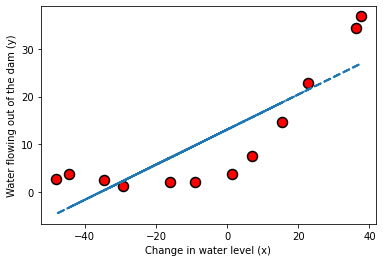

In [8]:
X_aug = np.c_[np.ones(m), X]
theta = train_linear_reg(X_aug, y, lambda_)
#  Plot fit over the data
pyplot.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.plot(X, np.dot(X_aug, theta), '--', lw=2);

The best fit line tells us that the model is not a good fit to the data because the data has a non-linear pattern. While visualizing the best fit as shown is one possible way to debug your learning algorithm, it is not always easy to visualize the data and model. In the next section, you will implement a function to generate learning curves that can help you debug your learning algorithm even if it is not easy to visualize the
data.

<a id="section3"></a>
## 2 Bias-variance (10 pts)

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

Next, you will plot training and testing errors on a learning curve to diagnose bias-variance problems.

### 2.1 Learning Curves (10 pts)

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size. Your job is to fill in the function `learningCurve` in the next cell, so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, you should use different subsets of the original training set `X`. Specifically, for a training set size of $i$, you should use the first $i$ examples (i.e., `X[:i, :]`
and `y[:i]`).

You can use the `train_linear_reg` function to find the $\theta$ parameters. Note that the `lambda_` is passed as a parameter to the `learningCurve` function.
After learning the $\theta$ parameters, you should compute the error on the training and cross validation sets. Recall that the training error for a dataset is defined as

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$

In particular, note that the training error does not include the regularization term. One way to compute the training error is to use your existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. When you are computing the training set error, make sure you compute it on the training subset (i.e., `X[:n,:]` and `y[:n]`) instead of the entire training set. However, for the cross validation error, you should compute it over the entire cross validation set. You should store
the computed errors in the vectors error train and error val.

<a id="func2"></a>

In [9]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    """
    Generates the train and cross validation set errors needed to plot a learning curve
    returns the train and cross validation set errors for a learning curve. 
    
    In this function, you will compute the train and test errors for
    dataset sizes from 1 up to m. In practice, when working with larger
    datasets, you might want to do this in larger intervals.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    error_train : array_like
        A vector of shape m. error_train[i] contains the training error for
        i examples.
    error_val : array_like
        A vecotr of shape m. error_val[i] contains the validation error for
        i training examples.
    
    Instructions
    ------------
    Fill in this function to return training errors in error_train and the
    cross validation errors in error_val. i.e., error_train[i] and 
    error_val[i] should give you the errors obtained after training on i examples.
    
    Notes
    -----
    - You should evaluate the training error on the first i training
      examples (i.e., X[:i, :] and y[:i]).
    
      For the cross-validation error, you should instead evaluate on
      the _entire_ cross validation set (Xval and yval).
    
    - If you are using your cost function (linearRegCostFunction) to compute
      the training and cross validation error, you should call the function with
      the lambda argument set to 0. Do note that you will still need to use
      lambda when running the training to obtain the theta parameters.
    
    Hint
    ----
    You can loop over the examples with the following:
     
           for i in range(1, m+1):
               # Compute train/cross validation errors using training examples 
               # X[:i, :] and y[:i], storing the result in 
               # error_train[i-1] and error_val[i-1]
               ....  
    """
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
         
    for i in range(1, m + 1) :
        mytheta = train_linear_reg(X[:i, :], y[:i], lambda_)
        
        error_train[i - 1], train_grad = linearRegCostFunction(X[:i, :], y[:i], mytheta, 0)
        error_val[i - 1], val_grad = linearRegCostFunction(Xval, yval, mytheta, 0)
    
    
        
    # =============================================================
    return error_train, error_val

When you are finished implementing the function `learningCurve`, executing the next cell prints the learning curves.

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	169.870708
  	2		0.000000	110.300366
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829961
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551431
  	12		22.373906	29.433818


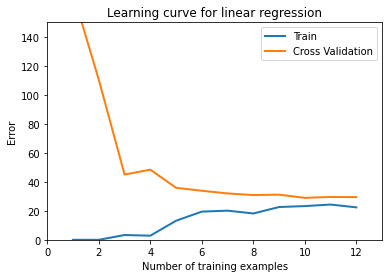

In [10]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

In the learning curve figure, you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model - the linear regression model is too simple and is unable to fit our dataset well. In the next section, you will implement polynomial regression to fit a better model for this dataset.

<a id="section4"></a>

## 3 Polynomial regression (30 pts)

The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). Next, you will address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, you will add more features using the higher powers of the existing feature $x$ in the dataset. Your task in this part is to complete the code in the function `polyFeatures` in the next cell. The function should map the original training set $X$ of size $m \times 1$ into its higher powers. Specifically, when a training set $X$ of size $m \times 1$ is passed into the function, the function should return a $m \times p$ matrix `X_poly`, where column 1 holds the original values of X, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on. Note that you don’t have to account for the zero-eth power in this function.

<a id="polyFeatures"></a>

### 3.1 Polynomial Features (10 pts)

In [11]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros((X.shape[0], p))

    # ====================== YOUR CODE HERE ======================

    for i in range(len(X)):
        term = np.zeros(p)
        
        for j in range(p):
            term[j] = np.power(X[i], j + 1)
        X_poly[i] = term

    # ============================================================
    return X_poly

After you have completed the function `polyFeatures`, we will proceed to train polynomial regression using your linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient that you wrote for the earlier part of this exercise.

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$). Therefore, you will
need to use feature normalization.

Before learning the parameters $\theta$ for the polynomial regression, you need to define `feature_normalize` and normalize the features of the training set, storing the mu, sigma parameters separately. 

### 3.2 Feature Normalization (10 pts)

In [12]:
def feature_normalize(X):
    
     # ====================== YOUR CODE HERE ======================

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma
    

    # ============================================================

    return X_norm, mu, sigma

Now you have a function that will map features to a higher dimension. The next cell will apply it to the training set, the test set, and the cross validation set. You also need to normalize all three sets.

In [13]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = feature_normalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0, :]

Normalized Training Example 1:


array([ 1.        , -0.3782437 , -0.78866232,  0.19032872, -0.7375913 ,
        0.32025197, -0.6171516 ,  0.35983501, -0.53109126])

### 3.3 Learning Polynomial Regression



After learning the parameters $\theta$, you should see two plots generated for polynomial regression with $\lambda = 0$, which should be similar to the ones here:

<table>
    <tr>
        <td><img src="Figures/polynomial_regression.png"></td>
        <td><img src="Figures/polynomial_learning_curve.png"></td>
    </tr>
</table>

You should see that the polynomial fit is able to follow the datapoints very well, thus, obtaining a low training error. The figure on the right shows that the training error essentially stays zero for all numbers of training samples. However, the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well.

To better understand the problems with the unregularized ($\lambda = 0$) model, you can see that the learning curve  shows the same effect where the training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

In [14]:
def plot_fit(min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x - 15, max_x + 25, 0.05)

    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    X_poly = np.c_[np.ones(x.size), X_poly]

    pyplot.plot(x, np.dot(X_poly, theta))

Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	99.523441
  	2		0.000000	99.488128
  	3		0.000000	58.435620
  	4		0.000000	77.026480
  	5		0.000000	6.599955
  	6		0.000000	10.623478
  	7		0.000000	27.771838
  	8		0.000133	20.146695
  	9		0.000013	25.389145
  	10		0.010994	104.912059
  	11		0.031448	46.404321
  	12		0.030418	37.314545


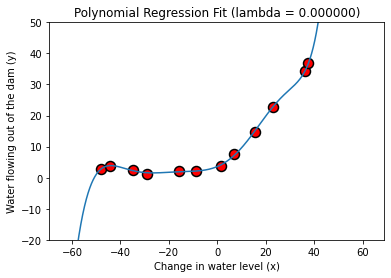

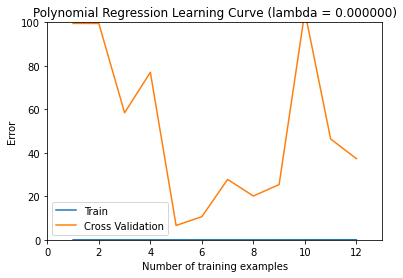

In [15]:
lambda_ = 0
theta = train_linear_reg(X_poly, y,
                             lambda_=lambda_)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plot_fit(np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In the next section, you will get to  try different $\lambda$ parameters to see how regularization can lead to a better model.

### 3.4 Optional (bonus) exercise: Adjusting the regularization parameter (5 pts)

In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression. You should now modify the the lambda parameter and try $\lambda = 1, 100$. For each of these values, the script should generate a polynomial fit to the data and also a learning curve.

For $\lambda = 1$, you should see a polynomial fit that follows the data trend well and a learning curve showing that both the cross validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have the high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

For $\lambda = 100$, you should see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

#### When $\lambda = 1$,

Polynomial Regression (lambda = 1.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	138.846777
  	2		0.042838	143.502514
  	3		2.515217	5.749648
  	4		1.285539	6.890108
  	5		1.028320	6.900649
  	6		0.794931	8.581249
  	7		1.409966	5.842256
  	8		1.316245	5.575868
  	9		1.458733	6.300293
  	10		1.353299	6.033552
  	11		1.228539	6.089707
  	12		1.958690	4.263361


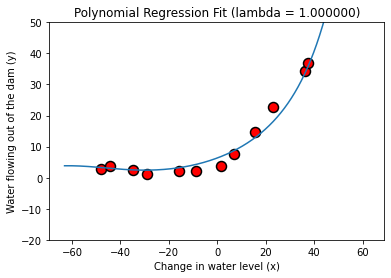

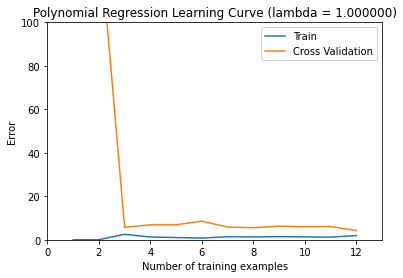

In [16]:

lambda_ = 1
theta = train_linear_reg(X_poly, y,
                             lambda_=lambda_)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plot_fit(np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

#### When $\lambda = 100$,

Polynomial Regression (lambda = 100.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	138.846777
  	2		0.113986	144.124029
  	3		105.959154	70.036421
  	4		119.945266	76.910550
  	5		100.886409	62.513581
  	6		95.257493	58.094607
  	7		81.688103	58.149056
  	8		74.884565	57.213733
  	9		69.819509	58.029731
  	10		62.964045	58.171822
  	11		57.731689	58.833235
  	12		56.725819	56.287764


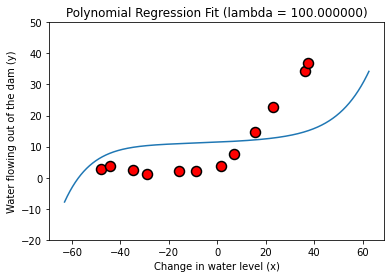

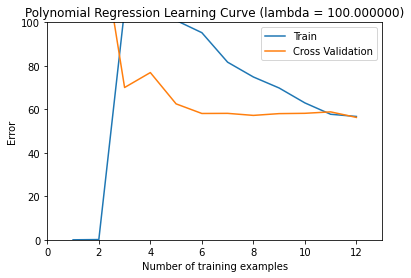

In [17]:
lambda_ = 100
theta = train_linear_reg(X_poly, y,
                             lambda_=lambda_)

# Plot training data and fit
pyplot.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

plot_fit(np.min(X), np.max(X), mu, sigma, theta, p)

pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')
pyplot.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
pyplot.ylim([-20, 50])

pyplot.figure()
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
pyplot.plot(np.arange(1, 1+m), error_train, np.arange(1, 1+m), error_val)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 13, 0, 100])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

<a id="section5"></a>
### 3.5 Selecting $\lambda$ using a cross validation set (10 pts)

From the previous parts, you observed that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda = 1$) can provide a good fit to the data.

In this section, you will implement an automated method to select the $\lambda$ parameter. Concretely, you will use a cross validation set to evaluate how good each $\lambda$ value is. After selecting the best $\lambda$ value using the cross validation set, we can then evaluate the model on the test set to estimate
how well the model will perform on actual unseen data. 

Your task is to complete the code in the function `validationCurve`. Specifically, you should should use the `train_linear_reg` function to train the model using different values of $\lambda$ and compute the training error and cross validation error. You should try $\lambda$ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}.
<a id="validationCurve"></a>

In [18]:
def validationCurve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda_.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The functions values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The functions values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross validation.
    
    error_train : list
        The training error computed at each value for the regularization
        parameter.
    
    error_val : list
        The validation error computed at each value for the regularization
        parameter.
    
    Instructions
    ------------
    Fill in this function to return training errors in `error_train` and
    the validation errors in `error_val`. The vector `lambda_vec` contains
    the different lambda parameters to use for each calculation of the
    errors, i.e, `error_train[i]`, and `error_val[i]` should give you the
    errors obtained after training with `lambda_ = lambda_vec[i]`.

    Note
    ----
    You can loop over lambda_vec with the following:
    
          for i in range(len(lambda_vec))
              lambda = lambda_vec[i]
              # Compute train / val errors when training linear 
              # regression with regularization parameter lambda_
              # You should store the result in error_train[i]
              # and error_val[i]
              ....
    """
    # Selected values of lambda (you should not change this)
    lambda_vec = np.array([0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])

    # You need to return these variables correctly.
    error_train = np.zeros(lambda_vec.size)
    error_val = np.zeros(lambda_vec.size)

    # ====================== YOUR CODE HERE ======================
    
    
    for i in range(len(lambda_vec)):
        mytheta = train_linear_reg(X, y, lambda_vec[i])
        
        error_train[i] = linearRegCostFunction(X, y, mytheta, 0)[0]
        error_val[i] = linearRegCostFunction(Xval, yval, mytheta, 0)[0]

    # ============================================================
    return lambda_vec, error_train, error_val

After you have completed the code, the next cell will run your function and plot a cross validation curve of error v.s. $\lambda$ that allows you select which $\lambda$ parameter to use.

lambda		Train Error	Validation Error
 0.000000	0.030418	37.314545
 0.001000	0.108191	9.364455
 0.003000	0.166715	15.920838
 0.010000	0.217954	17.148317
 0.030000	0.275148	13.221685
 0.100000	0.438697	7.926310
 0.300000	0.868177	4.760750
 1.000000	1.958690	4.263361
 3.000000	4.525094	3.832185
 10.000000	14.825787	8.889702


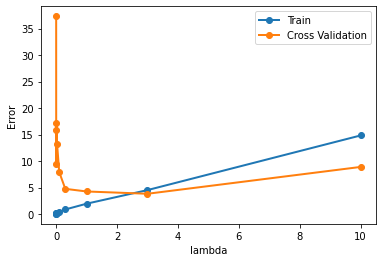

In [19]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

### 3.6  Optional (bonus): Computing test set error (5 pts)

In the previous part, you implemented code to compute the cross validation error for various values of the regularization parameter $\lambda$. However, to get a better indication of the model’s performance in the real world, it is important to evaluate the “final” model on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$). For this optional exercise, you should compute the test error using the best value of $\lambda$ you found. 

### 3.7 Optional (bonus): Plotting learning curves with randomly selected examples (10 pts)

In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for $i$ examples, you should first randomly select $i$ examples from the training set and $i$ examples from the cross validation set. You will then learn the parameters $\theta$ using the randomly chosen training set and evaluate the parameters $\theta$ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for $i$ examples.

For this optional question, you should implement the above strategy for computing the learning curves. For reference, the figure below  shows the learning curve we obtained for polynomial regression with $\lambda = 0.01$. Your figure may differ slightly due to the random selection of examples.

![](Figures/learning_curve_random.png)

## 4 Scikit-learn (40 pts)

In this part, you need to use scikit-learn (pipeline, GridSearchCV, etc.) to replicate section 3 (add polynomial features, normalize using StandardScaler, and run ridge regression) and pick the best ridge regressor by choosing the best $\lambda$. 

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.svm import SVC
from sklearn.compose import make_column_transformer

In [21]:
pipe = make_pipeline(PolynomialFeatures(), StandardScaler(),
                     Ridge(random_state = 3, max_iter = 5000))

pipe.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures()),
  ('standardscaler', StandardScaler()),
  ('ridge', Ridge(max_iter=5000, random_state=3))],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(),
 'standardscaler': StandardScaler(),
 'ridge': Ridge(max_iter=5000, random_state=3),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': 5000,
 'ridge__normalize': False,
 'ridge__random_state': 3,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [22]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4, 5],
              'ridge__alpha': [0.1, 1, 3, 5, 10], 
              'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

gridsearch = GridSearchCV(pipe, param_grid, cv = 5, return_train_score=True, n_jobs=-1)
model = gridsearch.fit(X, y)

In [23]:
model.best_params_

{'polynomialfeatures__degree': 5, 'ridge__alpha': 0.1, 'ridge__solver': 'auto'}

In [24]:
import pandas as pd
scores = pd.DataFrame(cross_validate(gridsearch, Xval, yval, cv = 3, n_jobs=-1, 
                                     return_train_score=True))
scores

,fit_time,score_time,test_score,train_score
0,6.368875,0.000499,0.910266,0.970603
1,6.283809,0.000914,0.855000,0.969018
2,6.284908,0.000488,0.849241,0.931457


In [25]:
scores.mean()

fit_time       6.312531
score_time     0.000634
test_score     0.871503
train_score    0.957026
dtype: float64

In [26]:
final_score = gridsearch.score(Xtest, ytest)
print("Test score: ", final_score)

Test score:  0.9365461266291356
